# Equity models

In [4]:
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [5]:
# Main functions
from src.Constants import *
from src.Utils import *

# Model simulation
from src.EquityModel import *
from src.BlackScholes import *
from src.Heston import *

from src.RatesModel import *
from src.Vasicek import *
from src.CIR import *
from src.HullWhite import *

In [6]:
!pip3 install QuantLib

## Preliminary

### Generation of 2 correlated Brownian Motions

**Remark**: We have to take into account the parameter $\rho \in \left[-1, 1\right]$ as the correlation between the two Brownian motions.

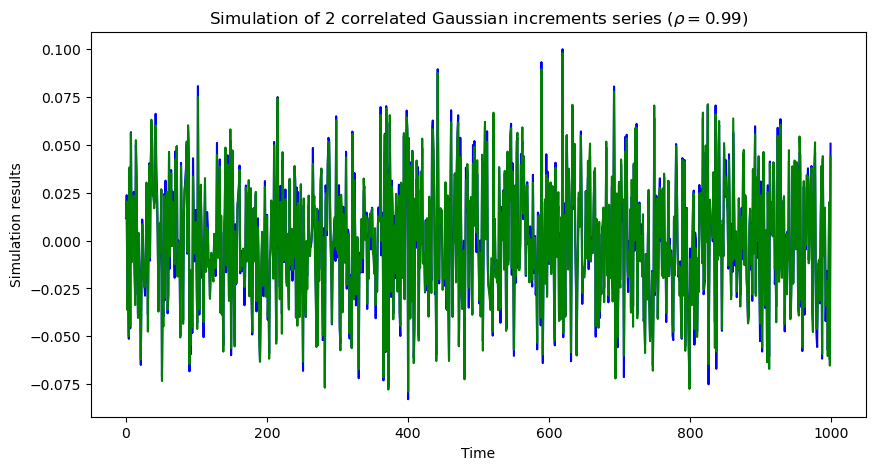

In [7]:
# Generation of Gaussian increments (Gaussian sequences)
rho_ = 0.99
for path in Utils.generate_correlated_gaussians(rho_, N=int(1e3)):
    plt.plot(path)
_ = plt.title(rf"Simulation of 2 correlated Gaussian increments series ($\rho =${rho_})")
_ = plt.xlabel("Time")
_ = plt.ylabel("Simulation results")

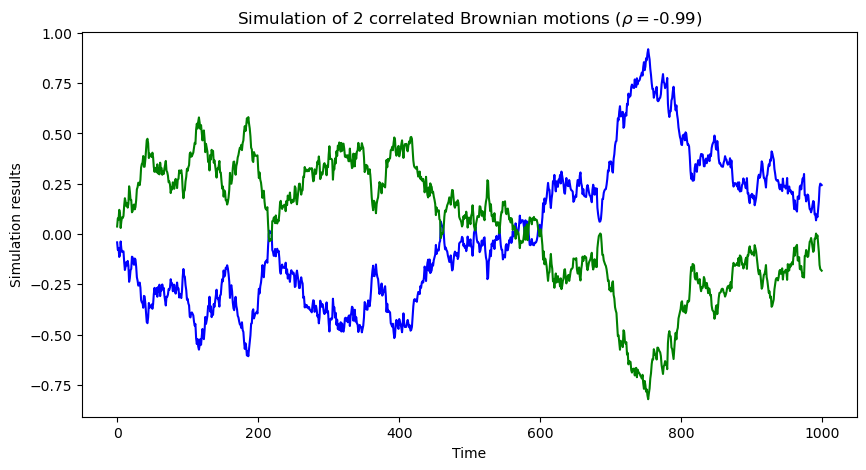

In [8]:
# Generation of Brownian motions (Cumulative sum of Gaussian increments)
for path in Utils.generate_correlated_brownians(-rho_, N=int(1e3)):
    plt.plot(path)
_ = plt.title(rf"Simulation of 2 correlated Brownian motions ($\rho =${-rho_})")
_ = plt.xlabel("Time")
_ = plt.ylabel("Simulation results")

### Generation of $k > 2$ correlated Brownian Motions

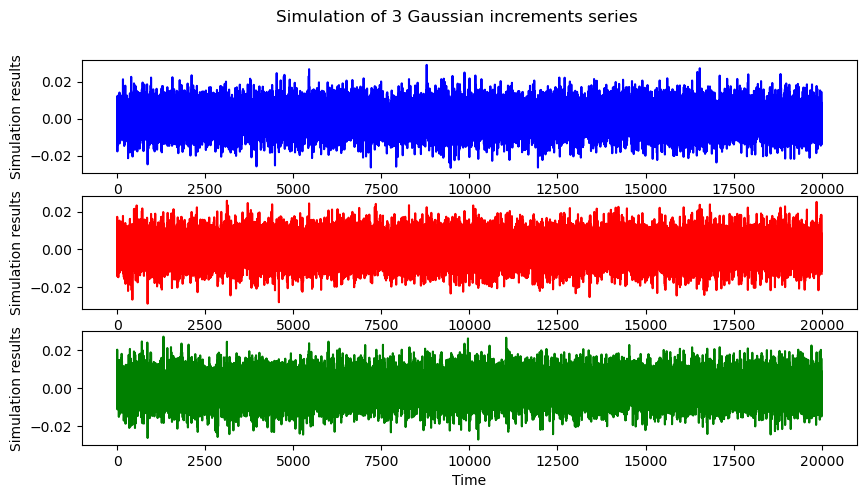

In [9]:
# Declaration of a correlation matrix
Sigma = np.array([
    [1, 0.8, 0.6],
    [0.8, 1, 0.7],
    [0.6, 0.7, 1]
])

colors = ["blue", "red", "green"]
# Simulation
sim_ = Utils.generate_correlated_gaussians(Sigma)
for i, path in enumerate(sim_):
    plt.subplot(len(sim_), 1, i + 1)
    _ = plt.plot(path, color=colors[i])
    _ = plt.ylabel("Simulation results")
_ = plt.suptitle(rf"Simulation of {len(Sigma)} Gaussian increments series")
_ = plt.xlabel("Time")

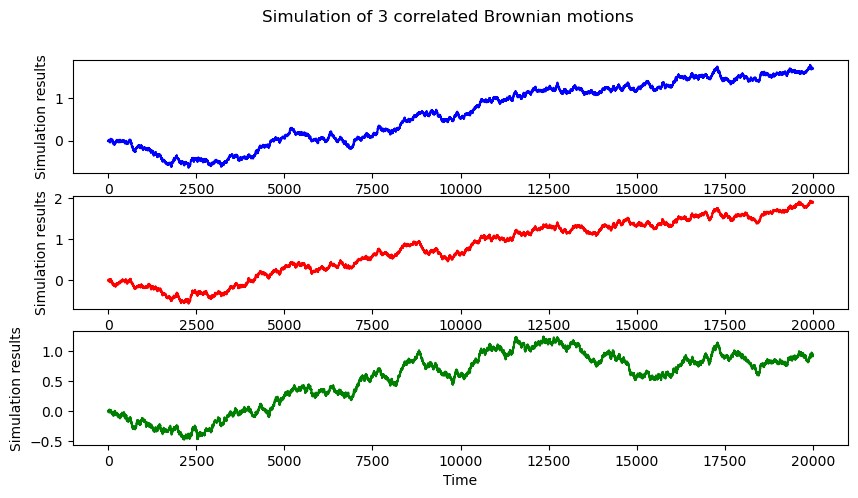

In [10]:
sim_ = Utils.generate_correlated_brownians(Sigma)
for i, path in enumerate(sim_):
    plt.subplot(len(sim_), 1, i + 1)
    _ = plt.plot(path, color=colors[i])
    _ = plt.ylabel("Simulation results")
_ = plt.suptitle(rf"Simulation of {len(Sigma)} correlated Brownian motions")
_ = plt.xlabel("Time")

## Black & Scholes

In [11]:
S0 = 1
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

In [12]:
model

Black-Scholes model (S0 = 1, sigma = 0.7)

In [13]:
# Simulation of 1 trajectory
d = model.simulate_euler(T=4.2, getRates=True)
df = pd.DataFrame(d)
df.head()

,t,S,r
0,0.00000,1.000000,0.400000
1,0.00021,0.991725,0.398950
2,0.00042,0.999035,0.398042
3,0.00063,0.991931,0.397243
4,0.00084,0.993919,0.396948


In [14]:
# Simulation of several trajectories
NB_TRAJECTORIES = 20
df_multi = Utils.cast_df(np.array(model.simulate_paths(M=NB_TRAJECTORIES)).T, columns = ["t"] + [f"S{k}" for k in range(1, NB_TRAJECTORIES + 1)] )
df_multi.head()

,t,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20
0,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.00005,0.998853,0.999418,0.997775,0.991216,0.998621,1.005462,0.993169,0.996996,1.000160,...,0.998270,0.997490,1.002420,0.994752,1.008859,0.997194,0.997297,1.002809,1.001821,0.994717
2,0.00010,0.994349,1.000316,0.995873,0.997262,1.002356,1.000261,0.992365,0.992721,0.999777,...,1.004561,0.998228,1.007859,0.992617,1.008558,0.992053,0.995032,0.999443,1.005232,0.997919
3,0.00015,0.993936,0.986072,0.988749,0.985555,0.996344,0.997604,0.985896,0.990171,1.000706,...,1.008407,1.003425,1.010396,0.989655,1.008032,0.995442,0.991839,0.999892,0.998984,0.987435
4,0.00020,0.996557,0.973716,0.988275,0.980110,0.994004,0.987761,0.992149,0.989364,1.005197,...,0.998568,1.005961,1.011088,0.986247,1.014589,0.993242,0.991080,1.001670,1.003841,0.983795


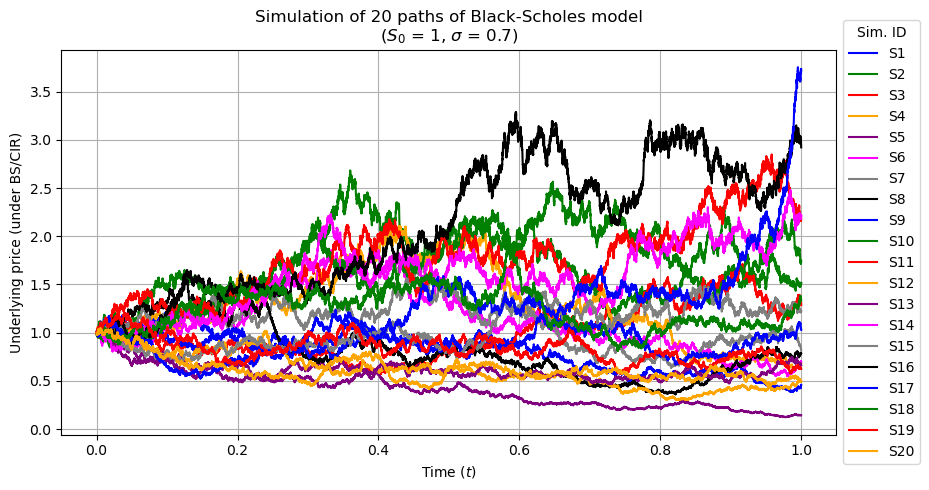

In [15]:
# Plotting the simulation paths
_ = df_multi.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Underlying price (under BS/CIR)")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Black-Scholes model\n{model.get_parameter_string()}")
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Sim. ID")

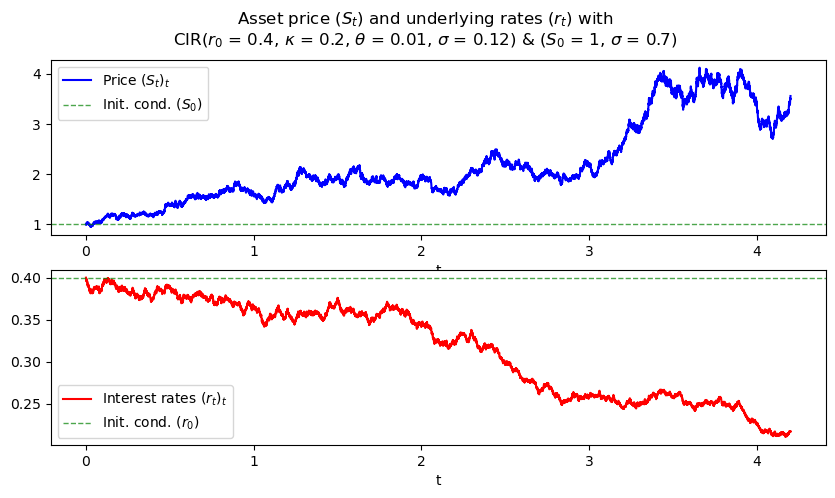

In [16]:
# Plotting the asset price and the interest rates evolution over time 
_, axes = plt.subplots(nrows=2, ncols=1)
_ = df.plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$", ax=axes[0])
_ = axes[0].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
_ = df.plot(x = "t", y = "r", color="red", label="Interest rates $(r_t)_t$", ax=axes[1])
_ = axes[1].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
axes[0].legend()
axes[1].legend()
_ = plt.suptitle(f"Asset price $(S_t)$ and underlying rates $(r_t)$ with\n{r.MODEL_NAME}{r.get_parameter_string()} & {model.get_parameter_string()}")

## Heston

In [17]:
# Declaring parameters
S0 = 1
V0 = 0.02
Sigma = np.array([
    [1, 0.8, 0.6],
    [0.8, 1, 0.7],
    [0.6, 0.7, 1]
])
sigma = 0.7
rho = 0.5
kappa = 0.20
theta = 0.02
eta = 0.06

# Declaring models (rate + equity)
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = Heston(S0, V0, r, kappa, theta, eta, Sigma) 

In [18]:
model

Heston model (S0 = 1, kappa = 0.2, theta = 0.02, eta = 0.06)

In [19]:
# Simulation of 1 trajectory
d = model.simulate_milstein(getRates=True, getVariance=True)
df = pd.DataFrame(d)
df.head()

,t,S,V,r
0,0.00000,1.000000,0.020000,0.400000
1,0.00005,0.999682,0.019934,0.399667
2,0.00010,1.000628,0.020019,0.400020
3,0.00015,1.002283,0.020123,0.400348
4,0.00020,1.002163,0.020199,0.400292


In [20]:
# Simulation of several trajectories
NB_TRAJECTORIES = 20
df_multi = Utils.cast_df(np.array(model.simulate_paths(M=NB_TRAJECTORIES)).T, columns = ["t"] + [f"S{k}" for k in range(1, NB_TRAJECTORIES + 1)] )
df_multi.head()

,t,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20
0,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.00005,1.001578,1.001919,1.000156,1.002775,0.999778,1.000067,1.000437,1.000489,1.000098,...,1.002124,0.999586,1.002404,0.999003,0.999678,0.999225,0.998790,0.999660,0.999742,0.999782
2,0.00010,1.001272,1.003530,0.999526,1.001310,0.997707,0.999577,0.999793,1.000436,1.000400,...,1.001370,0.999621,1.000788,1.000784,0.999662,0.998649,0.997259,0.999382,0.999218,0.999876
3,0.00015,0.999614,1.005750,0.998858,1.000677,0.998087,0.998424,0.998747,1.000286,0.998514,...,1.000410,0.998892,1.001966,1.000678,1.002632,0.999323,0.998792,0.998945,0.999137,0.998634
4,0.00020,0.998515,1.005728,0.998920,1.002209,0.999711,0.997561,0.999698,1.000120,0.999452,...,1.001111,0.999625,1.001894,0.999799,1.003517,1.000147,0.998403,1.000053,0.997667,0.999916


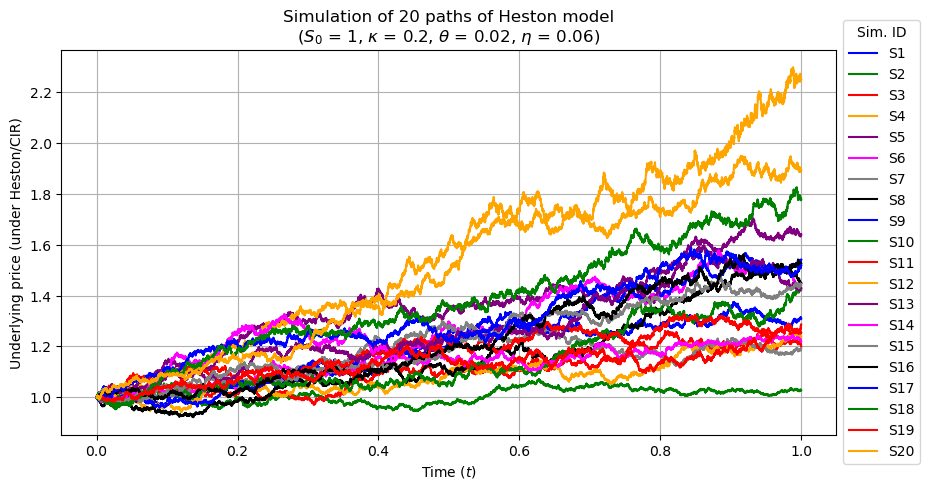

In [21]:
# Plotting the simulation paths
_ = df_multi.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Underlying price (under Heston/CIR)")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Heston model\n{model.get_parameter_string()}")
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Sim. ID")

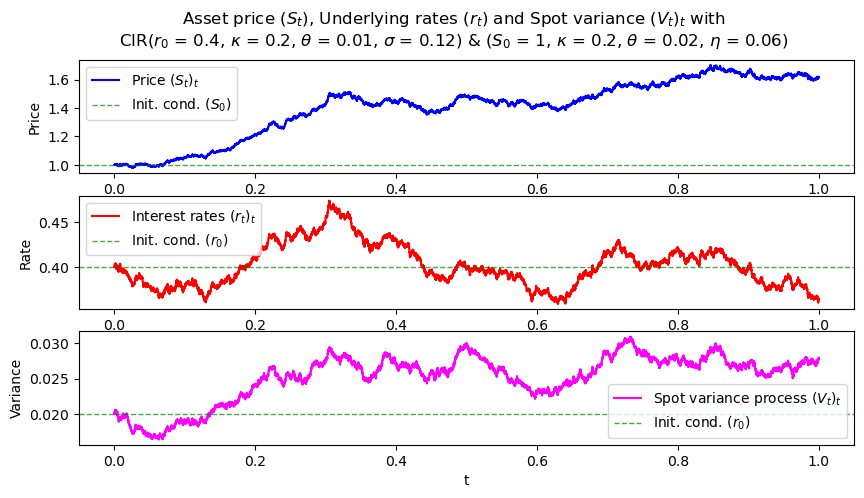

In [22]:
# Plotting the asset price and the interest rates evolution over time 
_, axes = plt.subplots(nrows=3, ncols=1)
_ = df.plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$", ax=axes[0])
_ = axes[0].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
_ = df.plot(x = "t", y = "r", color="red", label="Interest rates $(r_t)_t$", ax=axes[1])
_ = axes[1].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
_ = df.plot(x = "t", y = "V", color="magenta", label="Spot variance process $(V_t)_t$", ax=axes[2])
_ = axes[2].axhline(y = model.V0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")

# Plotting options
axes[0].legend()
axes[0].set_ylabel("Price")
axes[1].legend()
axes[1].set_ylabel("Rate")
axes[2].legend()
axes[2].set_ylabel("Variance")
_ = plt.suptitle(f"Asset price $(S_t)$, Underlying rates $(r_t)$ and Spot variance $(V_t)_t$ with\n{r.MODEL_NAME}{r.get_parameter_string()} & {model.get_parameter_string()}")

## Influence des paramètres de Heston / Vasicek
Dans cette étude, nous allons fixer les paramètres du modèle de Heston pour se concentrer sur l'influence des paramètres de Vasicek.

Lorsque l'on fixe les paramètres du modèle de Heston , nous faisons en sorte de respecter les conditions de Feller afin de nous assurer de ne pas avoir de variance négative : $2*\kappa * \theta > \eta^2 $ ' et donc ici 0.08 > 0.0036.

Les trajéctoires étant stochastique et non déterministe, nous simulons 10 trajectoires pour chaque valeur de paramètre et calculons la moyenne et la variance des trajectoires etudies, puis prenons la moyenne de toutes les moyennes calculés et toutes les variances calculés.

In [46]:
def PriceHestonVasicek(S0 = 1, V0 = 0.02 , kappa = 0.20 , theta = 0.02 , eta = 0.06,
                       p1 = 0.01875, p2 = 0.20 , p3 = 0.01 , p4 = 0.014 , corell1 = 0.8 , corell2 = 0.6 , corell3 = 0.7 ):
    Sigma = np.array([
        [1, corell1, corell2],
        [corell1, 1, corell3],
        [corell2, corell3, 1]
    ])

    # Declaring models (rate + equity)
    #r = CIR(0.4, 0.20, 0.01, 0.12)
    r = Vasicek(p1, p2, p3, p4)
    model = Heston(S0, V0, r, kappa, theta, eta, Sigma)
    # Simulation of several trajectories
    NB_TRAJECTORIES = 10
    df_multi = Utils.cast_df(np.array(model.simulate_paths(M=NB_TRAJECTORIES)).T, columns = ["t"] + [f"S{k}" for k in range(1, NB_TRAJECTORIES + 1)] )
    stats = df_multi.drop('t', axis=1).describe(include=[np.number]).loc[['mean', 'std']].mean(axis=1)
    return stats["mean"] , stats["std"]


### Etude de p1

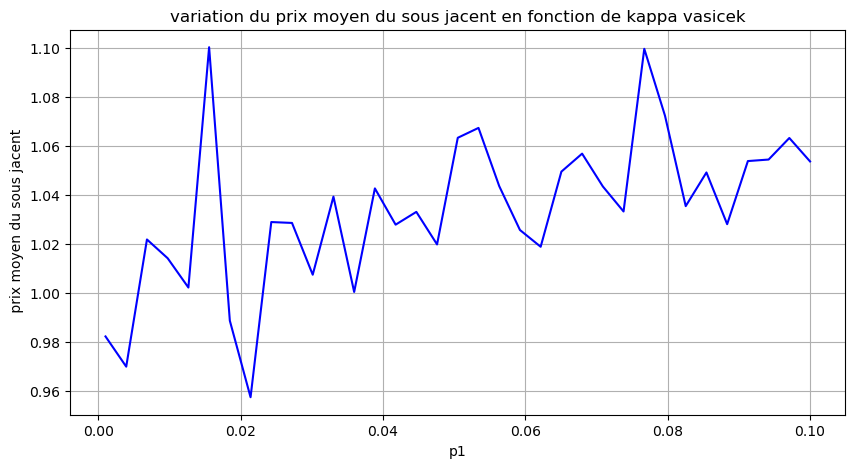

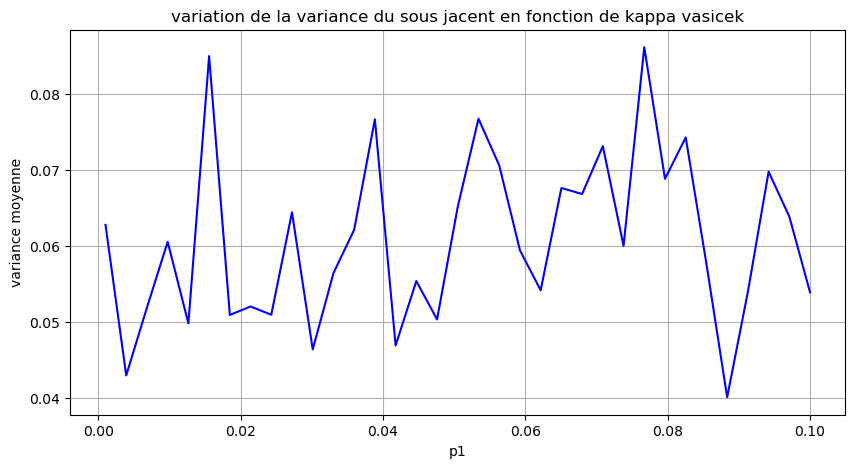

In [47]:
pEtude = np.linspace(0.001 , 0.1  , 35)
St = []
std = []
for p in pEtude:
    (m,v) = PriceHestonVasicek(p1 = p)
    St.append(m)
    std.append(v)
plt.plot(pEtude,St)
plt.title("variation du prix moyen du sous jacent en fonction de kappa vasicek")
plt.xlabel('p1')
plt.ylabel(' prix moyen du sous jacent')
plt.grid()
plt.show()
plt.title("variation de la variance du sous jacent en fonction de kappa vasicek")
plt.xlabel('p1')
plt.ylabel('variance moyenne')
plt.plot(pEtude,std)
plt.grid()
plt.show()


### Etude de p2

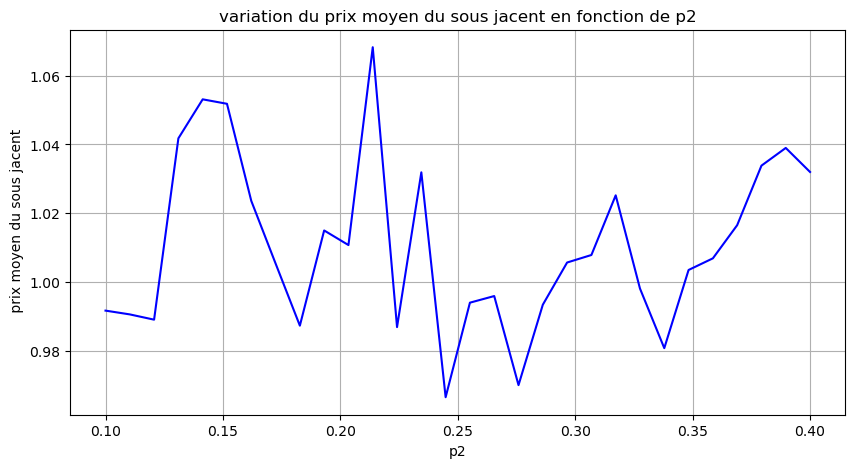

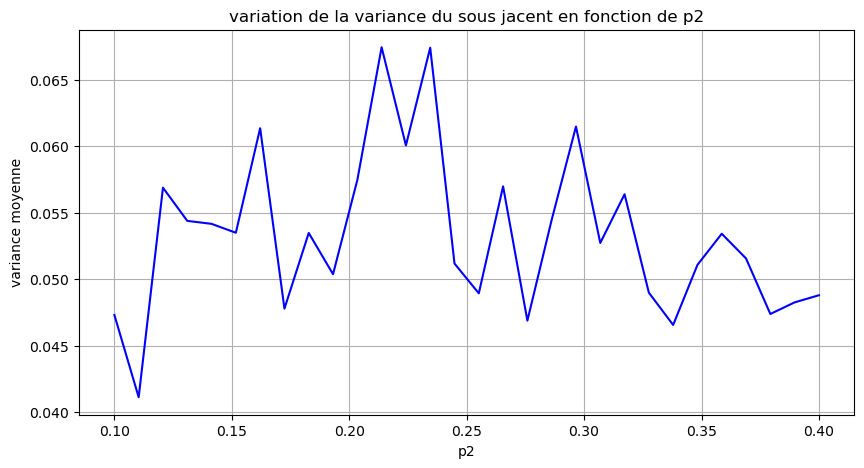

In [48]:
pEtude = np.linspace(0.1 , 0.4  , 30)
St = []
std = []
for p in pEtude:
    (m,v) = PriceHestonVasicek(p2 = p)
    St.append(m)
    std.append(v)
plt.plot(pEtude,St)
plt.title("variation du prix moyen du sous jacent en fonction de p2")
plt.xlabel('p2')
plt.ylabel(' prix moyen du sous jacent')
plt.grid()
plt.show()
plt.title("variation de la variance du sous jacent en fonction de p2")
plt.xlabel('p2')
plt.ylabel('variance moyenne')
plt.plot(pEtude,std)
plt.grid()
plt.show()


la variance semble augmenter lorsque p2 augmente.

### Etude de p3

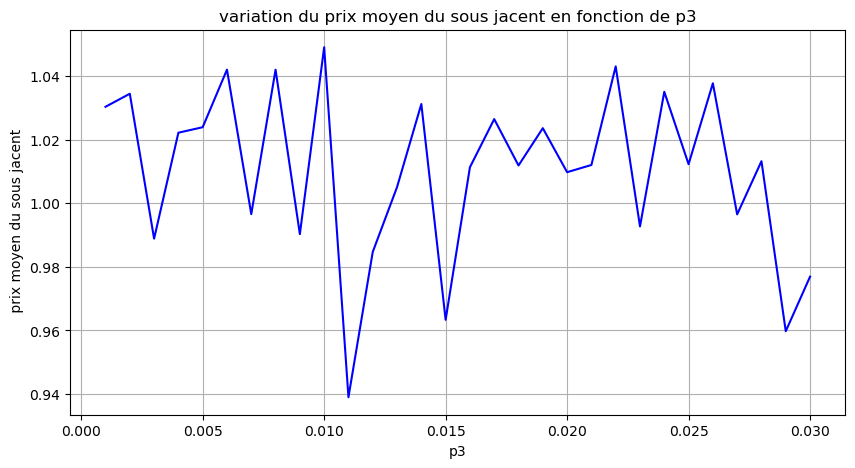

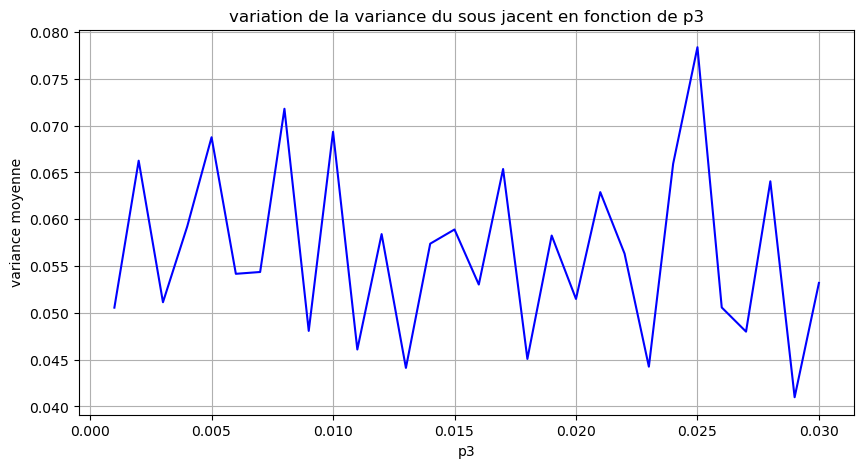

In [49]:
pEtude = np.linspace(0.001 , 0.03  , 30)
St = []
std = []
for p in pEtude:
    (m,v) = PriceHestonVasicek(p3 = p)
    St.append(m)
    std.append(v)
plt.plot(pEtude,St)
plt.title("variation du prix moyen du sous jacent en fonction de p3")
plt.xlabel('p3')
plt.ylabel(' prix moyen du sous jacent')
plt.grid()
plt.show()
plt.title("variation de la variance du sous jacent en fonction de p3")
plt.xlabel('p3')
plt.ylabel('variance moyenne')
plt.plot(pEtude,std)
plt.grid()
plt.show()

On remarque donc une augmentation de la variance ce qui suppose alors une augmentation du prix du Call ( asymétrie du payoff )

### Etude de p4

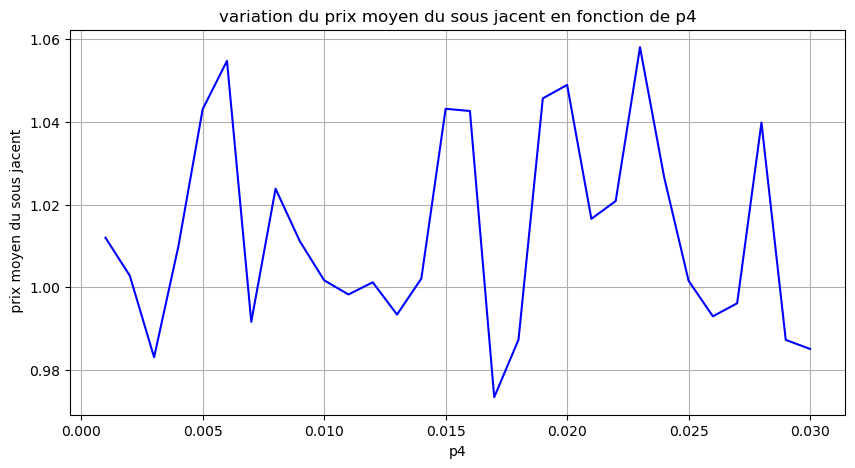

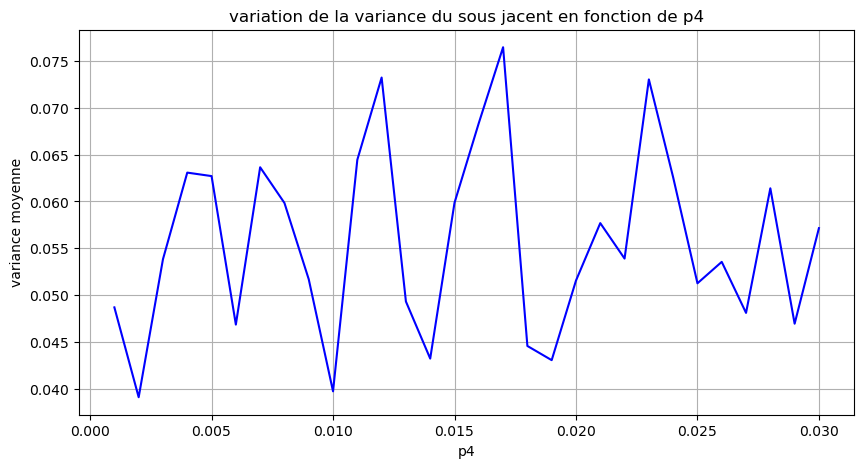

In [50]:
pEtude = np.linspace(0.001 , 0.03  , 30)
St = []
std = []
for p in pEtude:
    (m,v) = PriceHestonVasicek(p4 = p)
    St.append(m)
    std.append(v)
plt.plot(pEtude,St)
plt.title("variation du prix moyen du sous jacent en fonction de p4")
plt.xlabel('p4')
plt.ylabel(' prix moyen du sous jacent')
plt.grid()
plt.show()
plt.title("variation de la variance du sous jacent en fonction de p4")
plt.xlabel('p4')
plt.ylabel('variance moyenne')
plt.plot(pEtude,std)
plt.grid()
plt.show()

### Etude de la corrélation des browniens

## 1ere corrélation

Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix


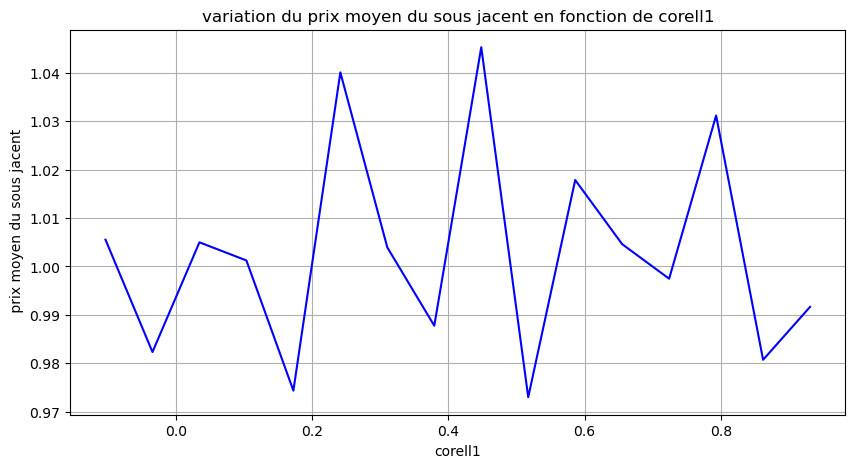

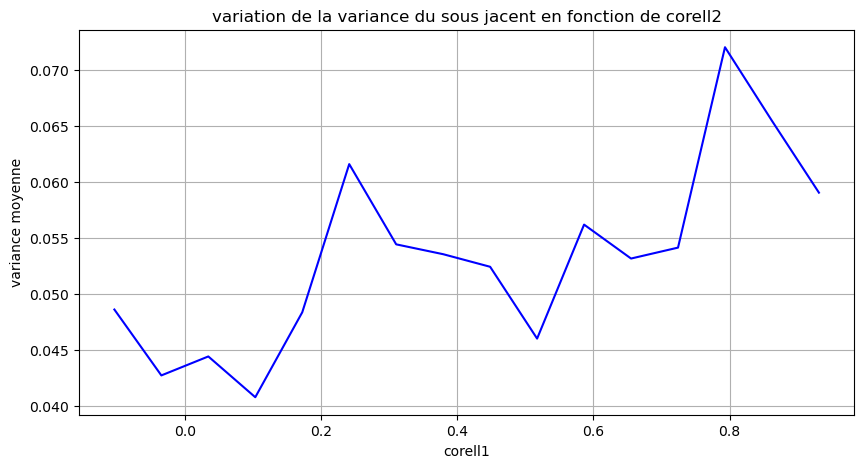

In [51]:
pEtude = np.linspace(-1 , 1  , 30)
St = []
std = []
abscisse = []
for p in pEtude:
    try:
        (m,v) = PriceHestonVasicek(corell1 = p)
        St.append(m)
        std.append(v)
        abscisse.append(p)
    except:
        pass
plt.plot(abscisse,St)
plt.title("variation du prix moyen du sous jacent en fonction de corell1")
plt.xlabel('corell1')
plt.ylabel(' prix moyen du sous jacent')
plt.grid()
plt.show()
plt.title("variation de la variance du sous jacent en fonction de corell2")
plt.xlabel('corell1')
plt.ylabel('variance moyenne')
plt.plot(abscisse,std)
plt.grid()
plt.show()

Diminution globale du prix du sous-jacent donc diminution du prix d'un call européen

## 2eme corrélation

Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix


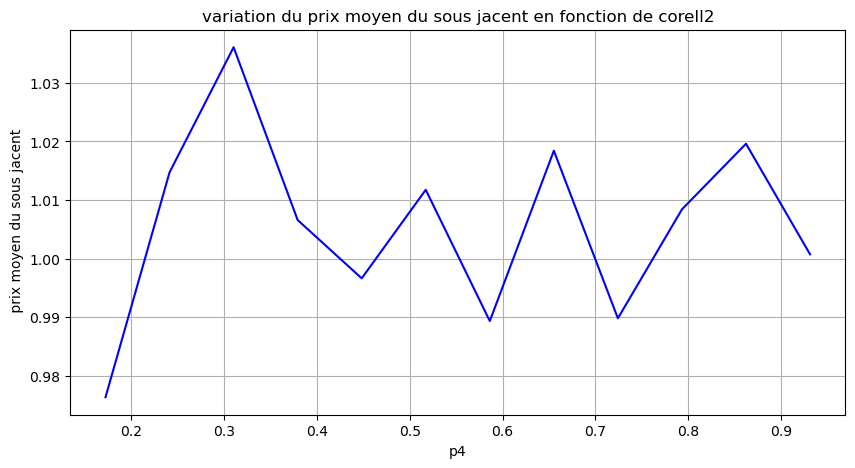

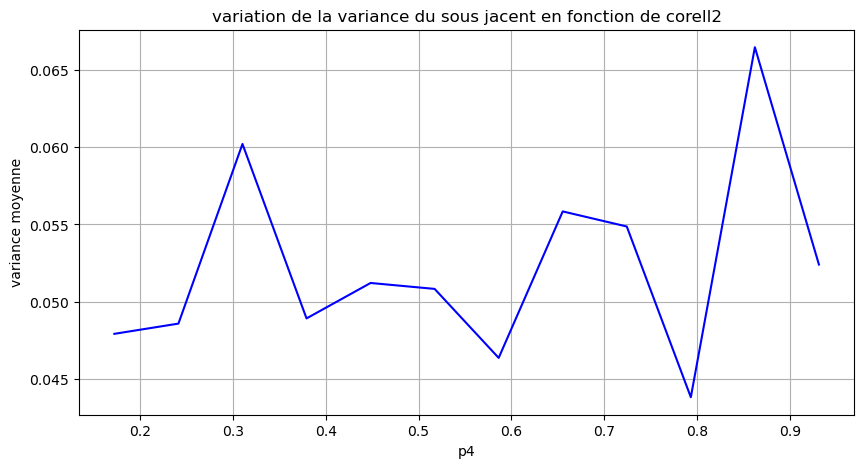

In [52]:
pEtude = np.linspace(-1 , 1  , 30)
St = []
std = []
abscisse = []
for p in pEtude:
    try:
        (m,v) = PriceHestonVasicek(corell2 = p)
        St.append(m)
        std.append(v)
        abscisse.append(p)
    except:
        pass
plt.plot(abscisse,St)
plt.title("variation du prix moyen du sous jacent en fonction de corell2")
plt.xlabel('p4')
plt.ylabel(' prix moyen du sous jacent')
plt.grid()
plt.show()
plt.title("variation de la variance du sous jacent en fonction de corell2")
plt.xlabel('p4')
plt.ylabel('variance moyenne')
plt.plot(abscisse,std)
plt.grid()
plt.show()

Cas complexe : Diminution du sous-jacent mais en même temps une diminution de la variance. Il fauddrait donc faire une analyse plus fine pour savoir qui influence le plus la variation du prix du Call dans ce cas.

### 3ème corrélation

Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix
Please set a positive definite correlation matrix


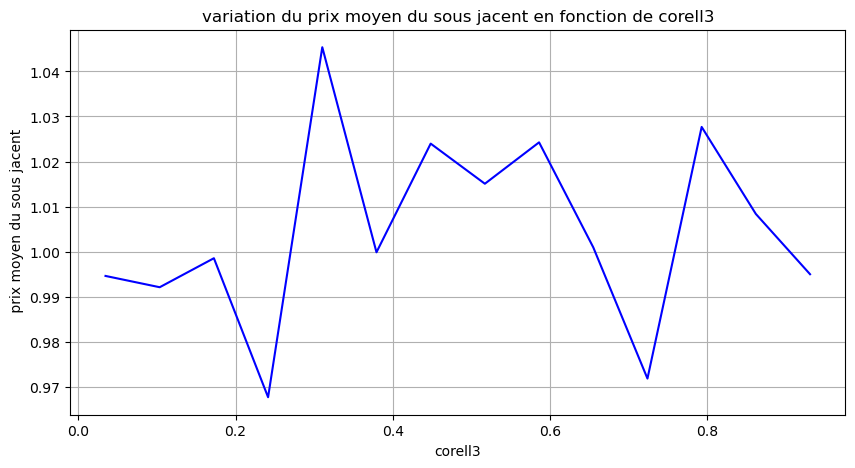

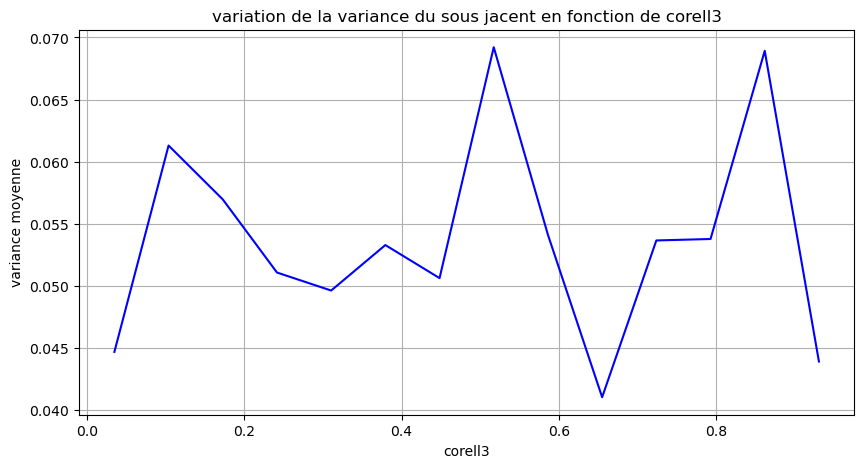

In [53]:
pEtude = np.linspace(-1 , 1  , 30)
St = []
std = []
abscisse = []
for p in pEtude:
    try:
        (m,v) = PriceHestonVasicek(corell3 = p)
        St.append(m)
        std.append(v)
        abscisse.append(p)
    except:
        pass
plt.plot(abscisse,St)
plt.title("variation du prix moyen du sous jacent en fonction de corell3")
plt.xlabel('corell3')
plt.ylabel(' prix moyen du sous jacent')
plt.grid()
plt.show()
plt.title("variation de la variance du sous jacent en fonction de corell3")
plt.xlabel('corell3')
plt.ylabel('variance moyenne')
plt.plot(abscisse,std)
plt.grid()
plt.show()

On observe une chute du prix du sous-jacent pour des valeurs entre 0.3 et 0.6 ce qui engendrer à son tour une diminution du prix du call pour cette fourchette de valeur.